In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

%matplotlib inline

/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
titanic = pd.read_csv('data/train.csv', index_col='PassengerId')

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

0    549
1    342
Name: Survived, dtype: int64


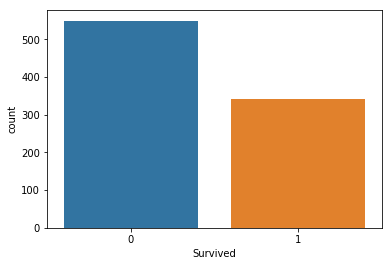

In [5]:
print(titanic.Survived.value_counts())
sns.countplot(titanic['Survived']);

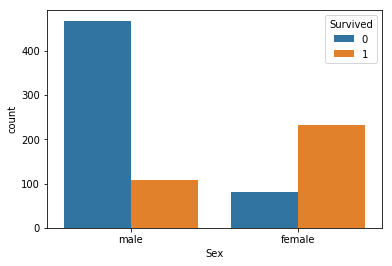

In [6]:
sns.countplot(titanic['Sex'], hue=titanic['Survived'])

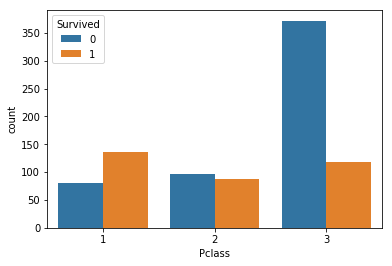

In [7]:
sns.countplot(titanic['Pclass'], hue=titanic['Survived'])

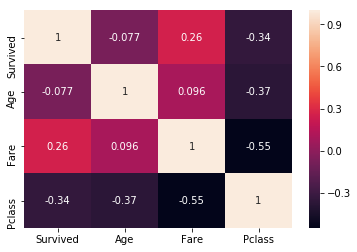

In [8]:
correlation = titanic[['Survived', 'Age', 'Fare', 'Pclass']].corr()
#correlation.describe()
sns.heatmap(correlation, annot=True)

In [9]:
titanic['Title'] = titanic['Name'].str.extract('.*, (.*?)\. .*', expand = False)

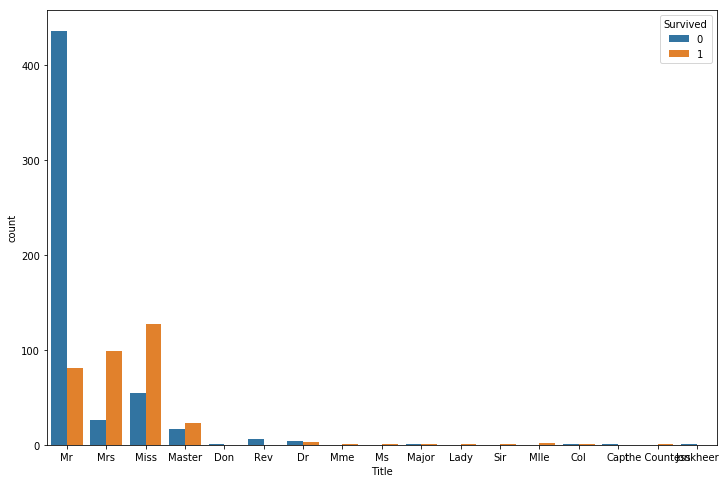

In [10]:
plt.figure(figsize=(12,8))
sns.countplot('Title', hue='Survived', data=titanic)

In [11]:
titles_dict = {
"Capt": "Officer",
"Col": "Officer",
"Major": "Officer",
"Jonkheer": "Royalty",
"Don": "Royalty",
"Sir" : "Royalty",
"Dr": "Officer",
"Rev": "Rev",
"the Countess": "Royalty",
"Dona": "Royalty",
"Mme": "Mrs",
"Mlle": "Miss",
"Ms": "Mrs",
"Mr" : "Mr",
"Mrs" : "Mrs",
"Miss" : "Miss",
"Master" : "Master",
"Lady" : "Royalty"
}    
titanic["Title"] = titanic["Title"].apply(titles_dict.get)

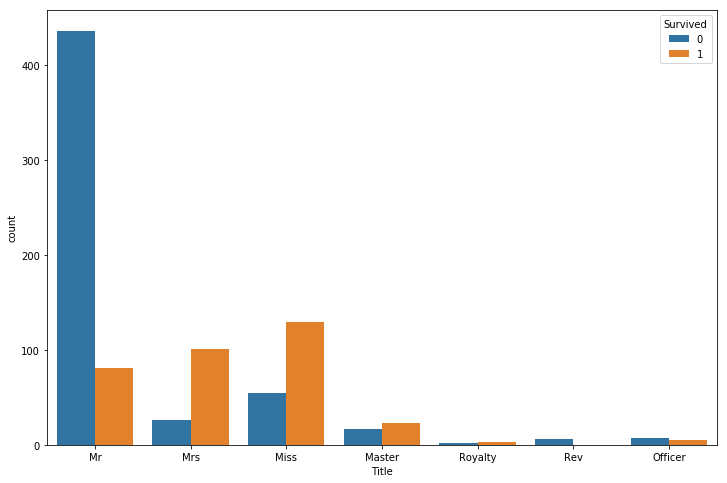

In [12]:
plt.figure(figsize=(12,8))
sns.countplot('Title', hue='Survived', data=titanic)

In [13]:
age_by_title = titanic.groupby('Title').Age.mean()
age_by_title

Title
Master      4.574167
Miss       21.804054
Mr         32.368090
Mrs        35.718182
Officer    48.636364
Rev        43.166667
Royalty    41.600000
Name: Age, dtype: float64

In [14]:
titanic.loc[titanic.Age.isnull() & (titanic.Title == 'Mr'), 'Age'] = age_by_title['Mr']
titanic.loc[titanic.Age.isnull() & (titanic.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
titanic.loc[titanic.Age.isnull() & (titanic.Title == 'Miss'), 'Age'] = age_by_title['Miss']
titanic.loc[titanic.Age.isnull() & (titanic.Title == 'Master'), 'Age'] = age_by_title['Master']
titanic.loc[titanic.Age.isnull() & (titanic.Title == 'Officer'), 'Age'] = age_by_title['Officer']
titanic.loc[titanic.Age.isnull() & (titanic.Title == 'Royalty'), 'Age'] = age_by_title['Royalty']
titanic.loc[titanic.Age.isnull() & (titanic.Title == 'Rev'), 'Age'] = age_by_title['Rev']

In [15]:
titanic['IsMr']      = (titanic.Title == 'Mr').astype(float)
titanic['IsMrs']     = (titanic.Title == 'Mrs').astype(float)
titanic['IsMiss']    = (titanic.Title == 'Miss').astype(float)
titanic['IsMaster']  = (titanic.Title == 'Master').astype(float)
titanic['IsOfficer']    = (titanic.Title == 'Officer').astype(float)
titanic['IsRoyalty']    = (titanic.Title == 'Royalty').astype(float)
titanic['IsRev']    = (titanic.Title == 'Rev').astype(float)

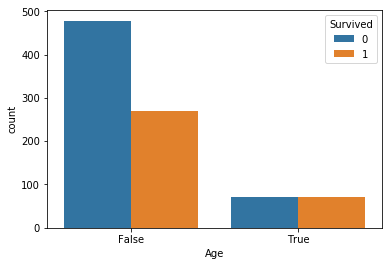

In [16]:
sns.countplot(titanic.Age <= 18, hue=titanic.Survived)
titanic['Kid'] = (titanic.Age <= 18).astype('float')

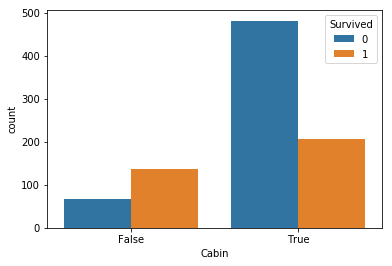

In [17]:
sns.countplot(titanic.Cabin.isnull(), hue=titanic.Survived)
# people without cabis have lower chance to survive
titanic['Have_Cabin'] = (~titanic.Cabin.isnull()).astype('float')

In [18]:
titanic['IsMale']    = (titanic.Sex == 'male').astype(float)
titanic['IsFemale']  = (titanic.Sex == 'female').astype(float)

In [19]:
titanic.Embarked = titanic.Embarked.fillna('S')

In [20]:
titanic['EmbarkedC'] = (titanic.Embarked == 'C').astype(float)
titanic['EmbarkedQ'] = (titanic.Embarked == 'Q').astype(float)
titanic['EmbarkedS'] = (titanic.Embarked == 'S').astype(float)

In [21]:
titanic['FamilySize'] = titanic.Parch + titanic.SibSp + 1

In [22]:
import re
titanic['Cabin_Class'] = titanic.Cabin[~titanic.Cabin.isna()].apply(lambda x: re.search('^([A-Z])', x).group(0))

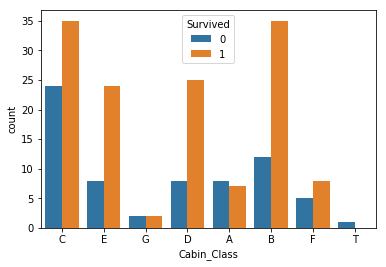

In [23]:
sns.countplot(titanic.Cabin_Class, hue=titanic.Survived)

In [24]:
print(titanic.columns)
titanic.describe()

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title', 'IsMr', 'IsMrs', 'IsMiss',
       'IsMaster', 'IsOfficer', 'IsRoyalty', 'IsRev', 'Kid', 'Have_Cabin',
       'IsMale', 'IsFemale', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS',
       'FamilySize', 'Cabin_Class'],
      dtype='object')


,Survived,Pclass,Age,SibSp,Parch,Fare,IsMr,IsMrs,IsMiss,IsMaster,...,IsRoyalty,IsRev,Kid,Have_Cabin,IsMale,IsFemale,EmbarkedC,EmbarkedQ,EmbarkedS,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.759889,0.523008,0.381594,32.204208,0.580247,0.142536,0.206510,0.044893,...,0.005612,0.006734,0.160494,0.228956,0.647587,0.352413,0.188552,0.086420,0.725028,1.904602
std,0.486592,0.836071,13.283620,1.102743,0.806057,49.693429,0.493796,0.349796,0.405028,0.207186,...,0.074743,0.081830,0.367270,0.420397,0.477990,0.477990,0.391372,0.281141,0.446751,1.613459
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,21.804054,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,3.000000,35.718182,1.000000,0.000000,31.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000


In [25]:
titanic['Cabin_Count'] = titanic.Cabin.apply(lambda x: 0 if str(x) == 'nan' else x.count(' ') + 1)

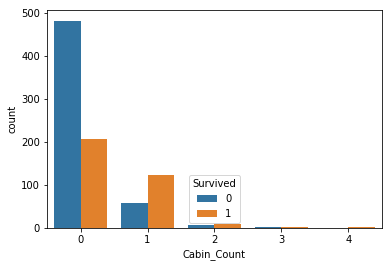

In [26]:
sns.countplot('Cabin_Count', hue='Survived', data=titanic)

In [30]:
titanic.describe().columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'IsMr', 'IsMrs',
       'IsMiss', 'IsMaster', 'IsOfficer', 'IsRoyalty', 'IsRev', 'Kid',
       'Have_Cabin', 'IsMale', 'IsFemale', 'EmbarkedC', 'EmbarkedQ',
       'EmbarkedS', 'FamilySize', 'Cabin_Count'],
      dtype='object')

In [31]:
X = titanic[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'IsMr', 'IsMrs',
       'IsMiss', 'IsMaster', 'IsOfficer', 'IsRoyalty', 'IsRev', 'Kid',
       'Have_Cabin', 'IsMale', 'IsFemale', 'EmbarkedC', 'EmbarkedQ',
       'EmbarkedS', 'FamilySize', 'Cabin_Count']]
Y = titanic.Survived

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_features='auto', 
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

parameters = {
             "min_samples_leaf" : [1, 5, 10],
             "min_samples_split" : [12, 16, 20, 24],
             "n_estimators": [100, 400, 700]}

gridSearch = GridSearchCV(estimator=classifier,
                  param_grid=parameters,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gridSearch = gridSearch.fit(X_train, Y_train)

In [37]:
gridSearch.score(X_test, Y_test)
gridSearch

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 5, 10], 'n_estimators': [100, 400, 700], 'min_samples_split': [12, 16, 20, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [36]:
from sklearn.linear_model import LogisticRegression
for c in [0.001, 0.003, 0.006, 0.1, 0.3, 0.6, 1.0, 3.0, 6.0]:
    model = LogisticRegression(C=c)
    model.fit(X_train, Y_train)
    
    print("C={:f} train: {:f} test: {:f}".format(c, model.score(X_train, Y_train), model.score(X_test, Y_test)))

C=0.001000 train: 0.727545 test: 0.632287
C=0.003000 train: 0.739521 test: 0.681614
C=0.006000 train: 0.751497 test: 0.717489
C=0.100000 train: 0.820359 test: 0.789238
C=0.300000 train: 0.830838 test: 0.798206
C=0.600000 train: 0.836826 test: 0.825112
C=1.000000 train: 0.832335 test: 0.829596
C=3.000000 train: 0.833832 test: 0.829596
C=6.000000 train: 0.833832 test: 0.829596


In [38]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)


/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


(0.97155688622754488, 0.76681614349775784)

In [48]:
from sklearn.cross_validation import cross_val_score
cvs = cross_val_score(rf, X, Y, cv = 10)

/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/nbabulkov/.virtualenvs/ai-venv/lib/python3.5/s

In [49]:
cvs.mean()

0.8148655090228123

In [50]:
rg = LogisticRegression(C=1)
rg_cvs = cross_val_score(rg, X, Y, cv = 10)

In [52]:
rg_cvs.mean()

0.83395471569628865